In [1]:
import numpy as np
import pylab

In [2]:
# fonction plot
#TODO - change to a functional import statement
def gridplot(classifieur,train,test,n_points=50, classifier_type = 'gauss'):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))
    les_comptes = classifieur.compute_predictions(thegrid)
    
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolor='black', linewidth='1', label='grid')
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50,edgecolor='black', linewidth='1', label = 'train')
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50,edgecolor='black', linewidth='1', label = 'test')

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1 = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=1) 
    h2 = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=1) 
    h3 = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=1) 
    #handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    #pylab.legend(handles=[h1,h2,h3],labels=['grille','train','test'])
    pylab.legend(loc=2, fontsize='small')
    pylab.axis('equal')
    pylab.show()

    ## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

In [92]:
def onehotify(labels,num_classes):
    labels = labels.astype(int)
    onehots = np.zeros((labels.shape[0],num_classes))
    onehots[np.arange(labels.shape[0]),labels] = 1
    return onehots

class NeuralNet_single:
    def __init__(self,dimensions, num_classes,weight_decay=[0,0]):
        #initialize weights
        self.W1 = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[0]))),
                                                high=(1)/float((np.sqrt(dimensions[0]))),
                                                size=((dimensions[1],dimensions[0]))
                                               )
        self.W2 = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[1]))),
                                                high=(1)/float((np.sqrt(dimensions[1]))),
                                                size=((dimensions[2],dimensions[1]))
                                               )
        self.saved_W1 = self.W1
        self.saved_W2 = self.W2
        #initialize biases
        self.b1 = np.zeros((dimensions[1]))
        self.b2 = np.zeros((dimensions[2]))
        #used for early stopping
        self.saved_b1 = self.b1
        self.saved_b2 = self.b2
        
        self.num_classes = num_classes
        # weight decay is an array of length 2, first entry is used for L1 Loss, second for L2 Loss
        # the same weight decay is applied to both weight matrices
        self.weight_decay = weight_decay
        
        
    def loss(self,logit,label):
        loss = -np.log(logit[np.argmax(label)])
        return loss
    
    def softmax(self,x):
        #numerically stable by subtracting maximum value
        b = np.max(x)
        numerator = np.exp(x-b)
        return numerator/np.sum(numerator)
        
    def fprop(self,inp,labels=None):
        #determine product of all dimensions
        D = np.prod(inp.shape[:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((D))
        h_a = np.dot(self.W1,data) + self.b1
        h_s = np.maximum(0,h_a)

        o_a = np.dot(self.W2,h_s) + self.b2
        
        probs = self.softmax(o_a)
        if (type(labels)==type(None)):
            return probs

        loss = self.loss(probs,labels)
        reg_loss = self.weight_decay[0]*(np.sum(np.abs(self.W1)) + np.sum(np.abs(self.W2))) + \
                self.weight_decay[1]*(np.sum(np.square(self.W1))+ np.sum(np.square(self.W2)))
        loss += reg_loss
        cache = (inp,h_a,h_s,o_a,probs,labels)
        
        return loss, cache
        
    def bprop(self,cache):
        inp, h_a, h_s, o_a, probs,label = cache
        #grads of softmax function
        grad_oa = probs
        grad_oa[np.argmax(label)] -= 1
        #grads of layer 2
        grad_W2 = np.outer(grad_oa,h_s)
        grad_b2 = grad_oa
        grad_hs = np.dot(np.transpose(self.W2),grad_oa)

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(h_a>0,1,0))

        #grads of input layer
        grad_W1 = np.outer(grad_ha,inp)
        grad_b1 = grad_ha
        grad_inp = np.dot(np.transpose(self.W1),grad_ha)

        return (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def train(self,data_train, data_val, learning_rate, batch_size,early_stopping=False, num_epochs=1,verbose=True):

        features_train = data_train[:,:-1]
        labels_train = data_train[:,-1]
        
        features_val = data_val[:,:-1]
        labels_val=data_val[:,-1]
        
        onehotlabels_train = onehotify(labels_train,self.num_classes)
        last_accuracy = 0
        for epoch in range(num_epochs):
            for i in range(data_train.shape[0]/batch_size):
                loss = 0
                grad_inp = grad_W1 = grad_b1 = grad_ha = grad_hs = grad_W2 = grad_b2 = grad_oa = 0
                for j in range(batch_size):
                    sample_loss, cache = self.fprop(features_train[(i*batch_size)+j,:],onehotlabels_train[(i*batch_size)+j,:])
                    loss += sample_loss
                    (sample_grad_inp, sample_grad_W1, sample_grad_b1, sample_grad_ha,
                     sample_grad_hs,sample_grad_W2, sample_grad_b2, sample_grad_oa) = self.bprop(cache)
                    #sum grads
                    grad_W1 += sample_grad_W1
                    grad_b1 += sample_grad_b1
                    grad_W2 += sample_grad_W2
                    grad_b2 += sample_grad_b2
                
                loss /= batch_size
                grad_W1 /= batch_size
                grad_b1 /= batch_size
                grad_W2 /= batch_size
                grad_b2 /= batch_size
            
                #apply regularization
                grad_W1 += self.weight_decay[0]*np.sign(self.W1) + self.weight_decay[1]*(2*self.W1)
                grad_W2 += self.weight_decay[0]*np.sign(self.W2) + self.weight_decay[1]*(2*self.W2)

                #gradient descent
                self.W1 -= learning_rate*grad_W1
                self.b1 -= learning_rate*grad_b1
                self.W2 -= learning_rate*grad_W2
                self.b2 -= learning_rate*grad_b2
            accuracy = self.eval_accuracy(data_val)
            if (verbose):
                print 'Epoch: ' + repr(epoch+1) + ' Loss at end of epoch: ' + repr(loss) + " Validation accuracy: " + repr(accuracy)
            if (early_stopping and accuracy<last_accuracy):
                self.load_last_params()
                break
            last_accuracy=accuracy
            self.save_params()
        return last_accuracy

    def eval_accuracy(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        onehotlabels = onehotify(labels,self.num_classes)
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        accuracy = np.mean(np.equal(predictions,labels))
        return accuracy
    
    def compute_predictions(self,features):
        N = features.shape[0]
        probs = np.zeros((N,self.num_classes))
        for i in range(N):
            probs[i,:] = self.fprop(features[i,:])
        return probs
            
    def save_params(self):
        self.saved_W1 = self.W1
        self.saved_W2 = self.W2
        self.saved_b1 = self.b1
        self.saved_b2 = self.b2
        
    def load_last_params(self):
        self.W1 = self.saved_W1
        self.W2 = self.saved_W2
        self.b1 = self.saved_b1
        self.b2 = self.saved_b2
    
    def grad_check(self,data,epsilon, batch_size = 1):
        inp = data[:batch_size,:-1]
        labels = data[:batch_size,-1]
        onehotlabels = onehotify(labels,self.num_classes)

        actual_loss = grad_W1 = grad_b1 = grad_W2 = grad_b2 = 0
        
        for i in range(batch_size):
            sample_actual_loss,(cache) = self.fprop(inp[i,:],onehotlabels[i,:])
            (_,sample_grad_W1, sample_grad_b1, _,_,sample_grad_W2,sample_grad_b2,_) = self.bprop(cache)
            actual_loss += sample_actual_loss
            grad_W1 += sample_grad_W1
            grad_b1 += sample_grad_b1
            grad_W2 += sample_grad_W2
            grad_b2 += sample_grad_b2
        actual_loss /= batch_size
        grad_W1 /= batch_size
        grad_b1 /= batch_size
        grad_W2 /= batch_size
        grad_b2 /= batch_size

        #apply regularization
        grad_W1 += self.weight_decay[0]*np.sign(self.W1) + self.weight_decay[1]*(2*self.W1)
        grad_W2 += self.weight_decay[0]*np.sign(self.W2) + self.weight_decay[1]*(2*self.W2)
        
        #Gradient check on b2
        print 'Second Bias gradients'
        for i in range(self.b2.shape[0]):
            self.b2[i] += epsilon
            loss_perturbed_b2 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b2,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b2 += sample_loss_perturbed_b2
            loss_perturbed_b2 /= batch_size
            self.b2[i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            print 'Gradient b2[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b2[i])
            if grad_b2[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b2[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b2[i])
                
        #Gradient check on W2 weights
        print 'Second weight gradients'
        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                self.W2[i,j] += epsilon
                loss_perturbed_W2 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W2,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W2 += sample_loss_perturbed_W2
                loss_perturbed_W2 /= batch_size
                self.W2[i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                print 'Gradient W2[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W2[i,j])
                if grad_W2[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W2[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W2[i,j])

        #Gradient check on b1
        print 'First bias gradients'
        for i in range(self.b1.shape[0]):
            self.b1[i] += epsilon
            loss_perturbed_b1 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b1,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b1 += sample_loss_perturbed_b1
            loss_perturbed_b1 /= batch_size
            self.b1[i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            print 'Gradient b1[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b1[i])
            if grad_b1[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b1[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b1[i])
        #Gradient check on W1 weights
        print 'First weights gradients'
        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                self.W1[i,j] += epsilon
                loss_perturbed_W1 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W1,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W1 += sample_loss_perturbed_W1
                loss_perturbed_W1 /= batch_size
                self.W1[i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                print 'Gradient W1[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W1[i,j])
                if grad_W1[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W1[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr((check_grad/grad_W1[i,j]))
        
    


Data Set Up: 2 Moons

In [12]:
fname = "twomoons.txt"
data = np.loadtxt(open(fname,'r'))
np.random.shuffle(data)
train_split = int(0.6*data.shape[0])
val_split = int(0.8*data.shape[0])
data_train = data[:train_split,:]
data_val = data[train_split:val_split,:]
data_val_test = data[train_split:,:]
data_test = data[val_split:,:]

Experiment 1,2: Gradient Check on a single example

In [93]:
np.random.seed(123)
singleNN = NeuralNet_single([2,2,2],2, [1,1])
#take one example
# reshape data from single column vectore to single row vector
singleNN.grad_check(data,0.00001,1)

Second Bias gradients
Gradient b2[0]: Finite difference: 0.44619784294042114 Analytical: 0.44619660737153094
Ratio of grads: 1.0000027691131439
Gradient b2[1]: Finite difference: -0.44619537185042185 Analytical: -0.446196607371531
Ratio of grads: 0.99999723099394133
Second weight gradients
Gradient W2[0,0]: Finite difference: 1.6207619871977383 Analytical: 1.6207519871815887
Ratio of grads: 1.0000061699854319
Gradient W2[0,1]: Finite difference: -0.95702798859065286 Analytical: -0.95703840954285602
Ratio of grads: 0.99998911124976886
Gradient W2[1,0]: Finite difference: 2.3598164992755244 Analytical: 2.3598064993179046
Ratio of grads: 1.0000042376176279
Gradient W2[1,1]: Finite difference: 1.2623385027055178 Analytical: 1.2623280817143034
Ratio of grads: 1.0000082553746252
First bias gradients
Gradient b1[0]: Finite difference: 0.0 Analytical: 0.0
Ratio of grads: 1.0
Gradient b1[1]: Finite difference: -0.16515174556808176 Analytical: -0.16515191485397074
Ratio of grads: 0.9999989749686

Experiments 3,4: Gradient Check on minibatches

In [94]:
singleNN.grad_check(data,0.00001,10)

Second Bias gradients
Gradient b2[0]: Finite difference: 0.053246934861306265 Analytical: 0.053245698050682064
Ratio of grads: 1.0000232283671635
Gradient b2[1]: Finite difference: -0.053244461373225242 Analytical: -0.053245698050682078
Ratio of grads: 0.99997677413383412
Second weight gradients
Gradient W2[0,0]: Finite difference: 1.5094329214981881 Analytical: 1.5094227278082828
Ratio of grads: 1.0000067533698265
Gradient W2[0,1]: Finite difference: -1.1118814713384495 Analytical: -1.1118916555434293
Ratio of grads: 0.99999084064986998
Gradient W2[1,0]: Finite difference: 2.4711459523096835 Analytical: 2.4711357586912106
Ratio of grads: 1.0000041250742444
Gradient W2[1,1]: Finite difference: 1.4171915118765808 Analytical: 1.4171813277148768
Ratio of grads: 1.0000071862093471
First bias gradients
Gradient b1[0]: Finite difference: 0.027673527736027378 Analytical: 0.027673443432289592
Ratio of grads: 1.0000030463768628
Gradient b1[1]: Finite difference: -0.082504049281340031 Analytical

Experiment 5

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.72727272727272729


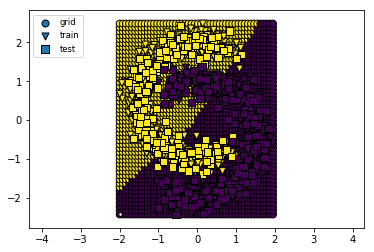

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.76818181818181819


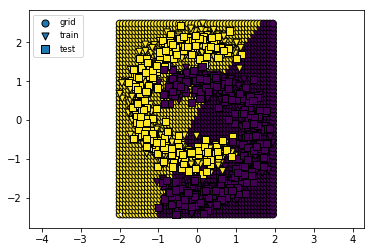

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.77727272727272723


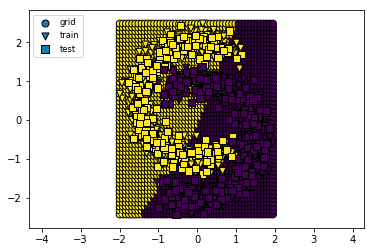

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.75909090909090904


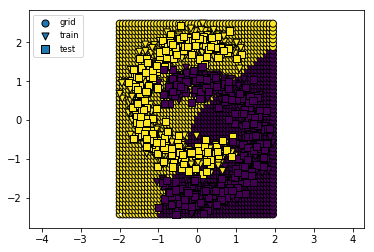

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.91818181818181821


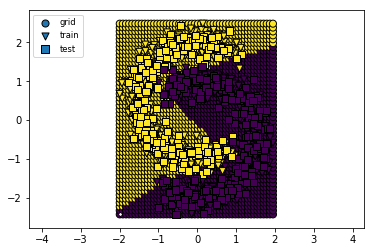

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.98181818181818181


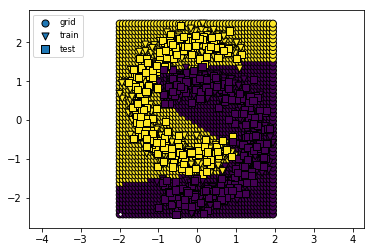

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.8954545454545455


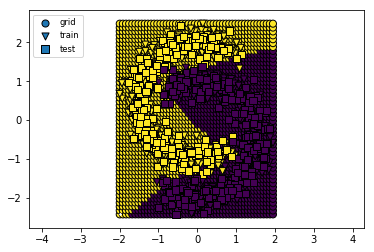

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.98181818181818181


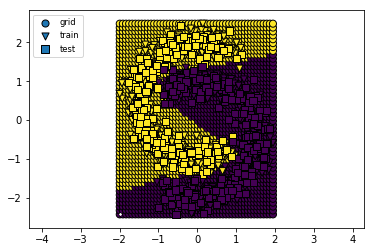

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.75


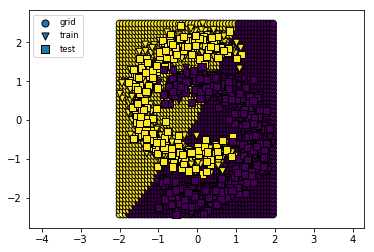

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.76818181818181819


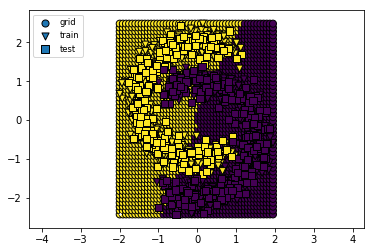

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.77272727272727271


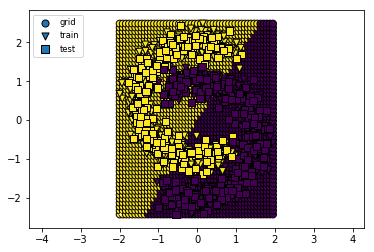

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.76818181818181819


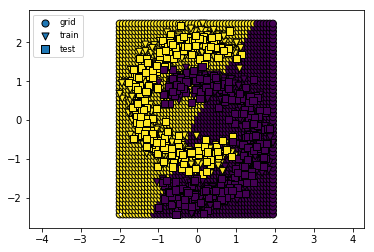

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.91818181818181821


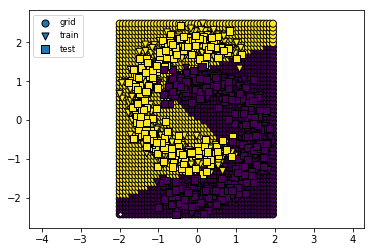

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.99090909090909096


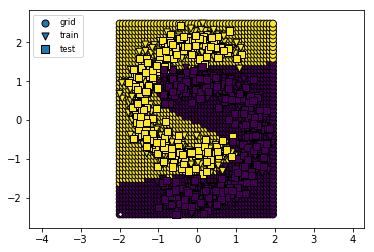

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.87727272727272732


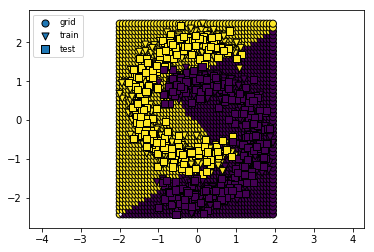

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.97727272727272729


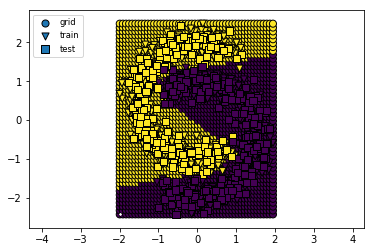

In [13]:
hyperparameters = {
    'n_hidden_units' : [[2,30,2],[2,100,2]],
    'early_stopping' : [True,False],
    'regularization' : [[0,0], [.001,.001]],
    'learning_rate' : [0.01,0.03]
}

for i in range(len(hyperparameters['n_hidden_units'])):
    for j in range(len(hyperparameters['early_stopping'])):
        for k in range(len(hyperparameters['regularization'])):
            for m in range(len(hyperparameters['learning_rate'])):
                print "Model Parameters: Number of hidden units: " + repr(hyperparameters['n_hidden_units'][i][1]) +\
                ", Early Stopping: " + repr(hyperparameters['early_stopping'][j]) + ", Regularization: " +\
                repr(hyperparameters['regularization'][k]) + ", Learning Rate: " + repr(hyperparameters['learning_rate'][m]) 
                model = NeuralNet_single(hyperparameters['n_hidden_units'][i],2,hyperparameters['regularization'][k])
                best_validation_accuracy = model.train(data_train,data_val,hyperparameters['learning_rate'][m],batch_size=25,
                            early_stopping=hyperparameters['early_stopping'][j],num_epochs=200,verbose=False)
                print "Best Validation accuracy:" + repr(best_validation_accuracy)
                gridplot(model,data_train,data_val_test)

In [95]:
def softmax(x):
    b = np.max(x)
    numerator = np.exp(x-b)
    probs = numerator/np.sum(numerator,axis=1,keepdims=True)
    return probs #Normalized probabilities of each class

class NeuralNet_matrix:
    
    def __init__(self,dimensions,num_classes,weight_decay=[0,0]):
        self.W1 = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[0]))),
                                                high=(1)/float((np.sqrt(dimensions[0]))),
                                                size=((dimensions[1],dimensions[0]))
                                               )
        self.W2 = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[1]))),
                                                high=(1)/float((np.sqrt(dimensions[1]))),
                                                size=((dimensions[2],dimensions[1]))
                                               )
        
        self.b1 = np.zeros((dimensions[1]))
        self.b2 = np.zeros((dimensions[2]))
        
        self.num_classes = num_classes
        self.weight_decay = weight_decay
    def loss(self,probs,labels):
        N = probs.shape[0]
        loss = -np.sum((np.log(probs[np.arange(N),labels])))
        loss /= N
        loss += self.weight_decay[0]*(np.sum(np.abs(self.W1))+np.sum(np.abs(self.W2))) + \
                self.weight_decay[1]*(np.sum(np.square(self.W1))+ np.sum(np.square(self.W2)))
        
        
        return loss
    
    def fprop(self,inp,labels=None):

        N = inp.shape[0]
        #determine product of all dimensions
        D = np.prod(inp.shape[1:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((N,D))

        h_a = np.dot(data,self.W1.T) + self.b1
        h_s = np.maximum(0,h_a)

        o_a = np.dot(h_s,self.W2.T) + self.b2
        probs = softmax(o_a)
        if (type(labels) == type(None)):
            return probs
        labels = labels.astype(np.int)
        loss = self.loss(probs,labels)
        cache = (inp,h_a,h_s,o_a,probs,labels)
        return loss, cache


    def bprop(self,cache):
        inp, h_a, h_s, o_a, probs,labels = cache
        N = inp.shape[0]
        #grads of softmax function
        grad_oa = probs
        
        grad_oa[np.arange(labels.shape[0]),labels] -= 1
        
        grad_W2 = np.dot(grad_oa.T,h_s)/N
        grad_b2 = np.sum(grad_oa,axis=0)/N
        grad_hs = np.dot(grad_oa,(self.W2))

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(h_a>0,1,0))

        #grads of input layer
        grad_W1 = np.dot(grad_ha.T,inp)/N
        grad_b1 = np.sum(grad_ha,axis=0)/N
        grad_x = np.dot(grad_ha,(self.W1))
        
        grad_W1 += self.weight_decay[0]*(np.sign(self.W1)) + self.weight_decay[1]*2*(self.W1)
        grad_W2 += self.weight_decay[0]*(np.sign(self.W2)) + self.weight_decay[1]*2*(self.W2)

        return (grad_x, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def grad_check(self,data,epsilon, batch_size = 1):
        
        inp = data[:batch_size,:-1]
        labels = data[:batch_size,-1]
        labels = labels.astype(int)
        actual_loss, cache = self.fprop(inp,labels)
        
        (_,grad_W1, grad_b1, _,_,grad_W2,grad_b2,_) = self.bprop(cache)
        #Gradient check on b2
        print "Second bias gradients"
        for i in range(self.b2.shape[0]):
            self.b2[i] += epsilon
            loss_perturbed_b2,_ = self.fprop(inp,labels)
            self.b2[i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            print 'Gradient b2[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b2[i])
            if grad_b2[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b2[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b2[i])
            
        #Gradient check on W2 weights
        print "Second weight gradients"
        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                self.W2[i,j] += epsilon
                loss_perturbed_W2,_ = self.fprop(inp,labels)
                self.W2[i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                print 'Gradient W2[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W2[i,j])
                if grad_W2[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W2[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W2[i,j])
                


        #Gradient check on b1
        print "First Bias Gradients:"
        for i in range(self.b1.shape[0]):
            self.b1[i] += epsilon
            loss_perturbed_b1,_ = self.fprop(inp,labels)
            self.b1[i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            print 'Gradient b1[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b1[i])
            if grad_b1[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b1[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b1[i])
            
        #Gradient check on W1 weights
        print "First Weight Gradients:"
        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                self.W1[i,j] += epsilon
                loss_perturbed_W1,_ = self.fprop(inp,labels)
                self.W1[i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                print 'Gradient W1[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W1[i,j])
                if grad_W1[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W1[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W1[i,j])
                

                    
    def train(self,data_train,learning_rate,batch_size,num_epochs=1,verbose=True,data_val=None,data_test=None):
        num_steps = int(float(data_train.shape[0]/float(batch_size)))
        self.train_error_epoch = [0]*num_epochs
        self.total_train_loss = [0]*num_epochs
        self.average_train_loss = [0]*num_epochs
        if (type(data_val) != type(None)):
            self.val_error = [0]*num_epochs
            self.val_loss = [0]*num_epochs
        if (type(data_test) != type(None)):
            self.test_error = [0]*num_epochs
            self.test_loss = [0]*num_epochs
        for epoch in range(num_epochs):
            for step in range(num_steps):
                lower_bound = (step*batch_size)%data_train.shape[0]
                upper_bound =(((step+1)*batch_size)%data_train.shape[0])
                if upper_bound < lower_bound:
                    upper_bound = data_train.shape[0]
                features = data_train[lower_bound:upper_bound,:-1]
                labels = data_train[lower_bound:upper_bound,-1]
                batch_loss, cache = self.fprop(features,labels)
                self.total_train_loss[epoch] += batch_loss
                self.train_error_epoch[epoch] += self.compute_error(data_train[(step*batch_size):(step+1)*batch_size,:])
                (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa) = self.bprop(cache)
                
                #Apply gradient descent
                self.W1 -= learning_rate*grad_W1
                self.b1 -= learning_rate*grad_b1
                self.W2 -= learning_rate*grad_W2
                self.b2 -= learning_rate*grad_b2
                #accuracy = self.eval_accuracy(data_val)
            self.train_error_epoch[epoch] /= float(data_train.shape[0])
            self.average_train_loss[epoch] = self.total_train_loss[epoch]/float(step)
            if (type(data_val) != type(None)):
                self.val_error[epoch] = 1-self.eval_accuracy(data_val)
                self.val_loss[epoch],_ = self.fprop(data_val[:,:-1],data_val[:,-1])
            if (type(data_test) != type(None)):
                self.test_error[epoch] = 1-self.eval_accuracy(data_test)
                self.test_loss[epoch],_ = self.fprop(data_test[:,:-1],data_test[:,-1])

            if (verbose):
                print "Epoch: " + repr(epoch+1) + ", Total Training Loss: " + repr(self.total_train_loss[epoch]) + \
                      ", Average Training Loss: " + repr(self.average_train_loss[epoch]) + ", Training Error: "+ repr(self.train_error_epoch[epoch])
                if (type(data_val) != type(None)):
                    print "Validation Loss: " + repr(self.val_loss[epoch]) + ", Validation Error: " + repr(self.val_error[epoch])
                if (type(data_test) != type(None)):
                    print "Test Loss: " + repr(self.test_loss[epoch]) + ", Test Error: " + repr(self.test_error[epoch])

    def eval_accuracy(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        onehotlabels = onehotify(labels,self.num_classes)
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        accuracy = np.mean(np.equal(predictions,labels))
        return accuracy
    
    def compute_predictions(self,features):
        N = features.shape[0]
        probs = self.fprop(features)
        return probs

    def compute_error(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        correct = np.sum(np.equal(predictions,labels))
        error = data.shape[0] - correct
        return error

Experiment 7: Gradient Check for Matrix and looping, batch size = 1

In [96]:
NN = NeuralNet_matrix([2,2,2],2,[10,10])
NN_single = NeuralNet_single([2,2,2],2,[10,10])
#set initial weights to be the same
NN_single.W1 = NN.W1
NN_single.W2 = NN.W2
NN_single.b1 = NN.b1
NN_single.b2 = NN.b2

batch_size=1

NN.grad_check(data_train,0.00001,batch_size)
NN_single.grad_check(data_train,0.00001,batch_size)


Second bias gradients
Gradient b2[0]: Finite difference: 0.31233458486212839 Analytical: 0.31233351092415418
Ratio of grads: 1.0000034384333947
Gradient b2[1]: Finite difference: -0.31233243689143819 Analytical: -0.31233351092415418
Ratio of grads: 0.99999656126327008
Second weight gradients
Gradient W2[0,0]: Finite difference: -11.737339293560465 Analytical: -11.737439293604224
Ratio of grads: 0.9999914802503973
Gradient W2[0,1]: Finite difference: -22.197123198708365 Analytical: -22.197223925932633
Ratio of grads: 0.9999954621701973
Gradient W2[1,0]: Finite difference: -12.883643937655618 Analytical: -12.883743937471046
Ratio of grads: 0.99999223829533457
Gradient W2[1,1]: Finite difference: 16.474661455490036 Analytical: 16.47456072875935
Ratio of grads: 1.0000061140768695
First Bias Gradients:
Gradient b1[0]: Finite difference: 0.0 Analytical: 0.0
Ratio of grads: 1.0
Gradient b1[1]: Finite difference: -0.29961612000306559 Analytical: -0.29961710845148065
Ratio of grads: 0.999996700

Experiment 7: Gradient Check for Matrix and looping, batch size = 10

In [97]:
NN = NeuralNet_matrix([2,2,2],2,[10,10])
NN_single = NeuralNet_single([2,2,2],2,[10,10])
#set initial weights to be the same
NN_single.W1 = NN.W1
NN_single.W2 = NN.W2
NN_single.b1 = NN.b1
NN_single.b2 = NN.b2

batch_size=10

NN.grad_check(data_train,0.00001,batch_size)
NN_single.grad_check(data_train,0.00001,batch_size)

Second bias gradients
Gradient b2[0]: Finite difference: 0.13272161822897033 Analytical: 0.13272037938025621
Ratio of grads: 1.0000093342764682
Gradient b2[1]: Finite difference: -0.13271914056645073 Analytical: -0.13272037938025621
Ratio of grads: 0.99999066598655562
Second weight gradients
Gradient W2[0,0]: Finite difference: -15.91407251950727 Analytical: -15.91417268169339
Ratio of grads: 0.99999370610159111
Gradient W2[0,1]: Finite difference: 13.712574297741751 Analytical: 13.712474142895877
Ratio of grads: 1.0000073039223141
Gradient W2[1,0]: Finite difference: -21.457389541268412 Analytical: -21.457489703879556
Ratio of grads: 0.99999533204431057
Gradient W2[1,1]: Finite difference: -11.883023789138745 Analytical: -11.883123944175241
Ratio of grads: 0.99999157165767472
First Bias Gradients:
Gradient b1[0]: Finite difference: -0.005477978248791259 Analytical: -0.005478028163752327
Ratio of grads: 0.99999088815179915
Gradient b1[1]: Finite difference: 0.009128680389380861 Analyti

MNIST Data Prep

In [98]:
import gzip,pickle
f=gzip.open('../mnist.pkl.gz')
data_MNIST=pickle.load(f)
data_train_MNIST = np.array(data_MNIST[0][0])
labels_train_MNIST = np.matrix(data_MNIST[0][1])

data_train_MNIST = np.concatenate((data_train_MNIST,labels_train_MNIST.T),axis=1)
data_train_MNIST = np.array(data_train_MNIST)

data_val_MNIST = np.array(data_MNIST[1][0])
labels_val_MNIST = np.matrix(data_MNIST[1][1])
data_val_MNIST = np.concatenate((data_val_MNIST,labels_val_MNIST.T), axis=1)
data_val_MNIST = np.array(data_val_MNIST)

data_test_MNIST = np.array(data_MNIST[2][0])
labels_test_MNIST = np.matrix(data_MNIST[2][1])

data_test_MNIST = np.concatenate((data_test_MNIST,labels_test_MNIST.T),axis=1)
data_test_MNIST = np.array(data_test_MNIST)
np.random.shuffle(data_train_MNIST)
np.random.shuffle(data_val_MNIST)
np.random.shuffle(data_test_MNIST)

Experiment 8: Time Epoch length with batch size = 100

In [99]:
import time
NN_mnist_matrix = NeuralNet_matrix([data_train_MNIST.shape[1]-1,95,10],10)
NN_mnist_loop = NeuralNet_single([data_train_MNIST.shape[1]-1,95,10],10)

start_time_matrix = time.time()
NN_mnist_matrix.train(data_train_MNIST,0.01,100,num_epochs=1,verbose=False)
fin_time_matrix = time.time()
tot_time_matrix = fin_time_matrix - start_time_matrix

start_time_loop = time.time()
NN_mnist_loop.train(data_train_MNIST, data_val_MNIST,0.01,100,num_epochs=1, verbose=False)
fin_time_loop = time.time()
tot_time_loop = fin_time_loop - start_time_loop
print "Matrix epoch time: " + repr(tot_time_matrix) + " Loop epoch time: " +  repr(tot_time_loop) 

Matrix epoch time: 0.7168898582458496 Loop epoch time: 11.405788898468018


Experiment 9: Calculate Train Error, Train Loss for each step. Calculate the Average Train Error per Epoch. Calculate Test Error, and Validation Error at the end of each epoch

In [103]:
NN_error_curves = NeuralNet_matrix([data_train_MNIST.shape[1]-1,30,10],10,[0.0,0.0001])
NN_error_curves.train(data_train_MNIST,.06,400,num_epochs=1000, data_val = data_val_MNIST, data_test=data_test_MNIST,verbose=False)

In [104]:
import matplotlib.pyplot as plt
def plot_model(model,name=None):
    plt.title("Error Curves")
    plt.xlabel("Epoch")
    plt.ylabel("% Error")
    plt.plot(model.train_error_epoch, label="Train error")
    plt.plot(model.val_error, label="Validation Error")
    if (hasattr(model,'test_error')):
        plt.plot(model.test_error, label="Test Error")
    plt.legend()
    if (type(name)!= type(None)):
        plt.savefig(name+"_ErrorCurve.png")
    plt.show()

    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(model.average_train_loss, label="Train Loss")
    plt.plot(model.val_loss,label="Validation Loss")
    if hasattr(model,'test_loss'):
        plt.plot(model.test_loss,label="Test Loss")
    plt.legend()
    if (type(name) != type(None)):
        plt.savefig(name+"_LossCurve.png")
    plt.show()

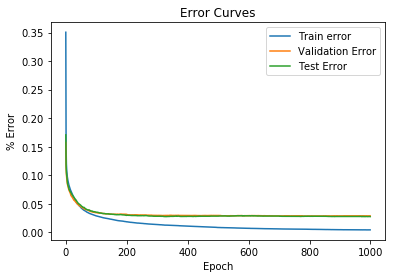

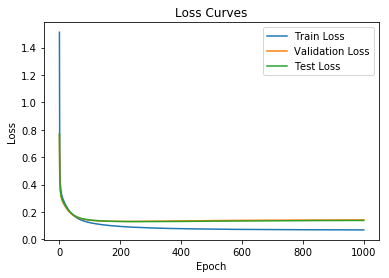

In [105]:
plot_model(NN_error_curves)

In [106]:
def to_logfile(model,name):
    filename = "log_"+name+".log"
    f_object = open(filename,mode='w')
    f_object.write("Epoch,Train Loss, Train Error, Validation Loss, Validation Error, Test Loss, Test Error\n")
    for epoch in range(len(model.train_error_epoch)):
        f_object.write(repr(epoch+1) + ",{:.4f},{:.4f},{:.4f},{:.4f},{:.4f},{:.4f}\n".format(model.average_train_loss[epoch],
                                                                            model.train_error_epoch[epoch],
                                                                            model.val_loss[epoch],
                                                                            model.val_error[epoch],
                                                                            model.test_loss[epoch],
                                                                            model.test_error[epoch]))
    f_object.close()

to_logfile(NN_error_curves,"error_curves")


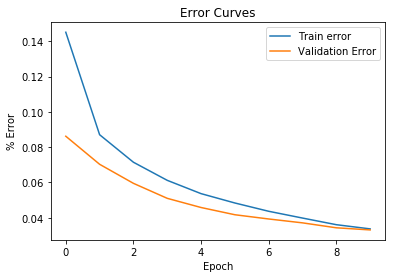

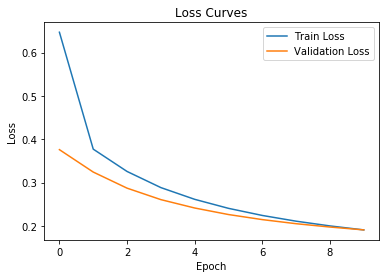

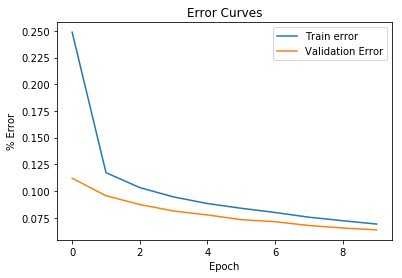

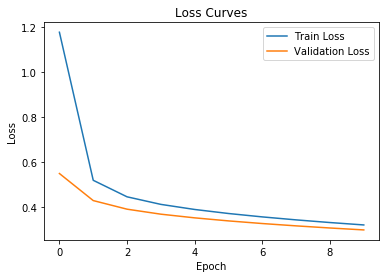

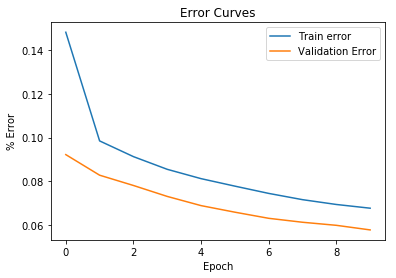

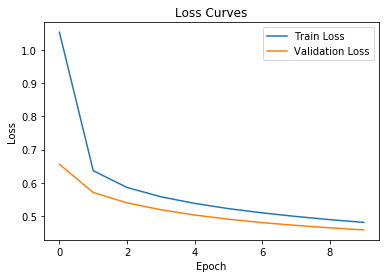

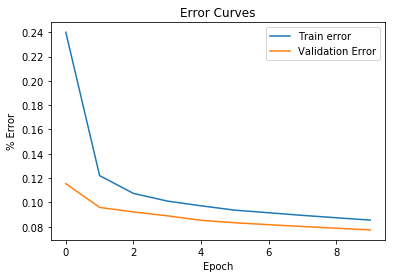

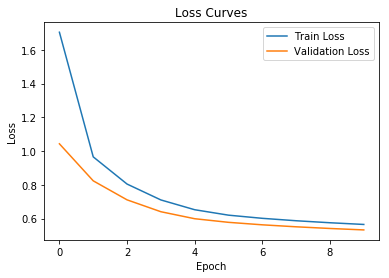

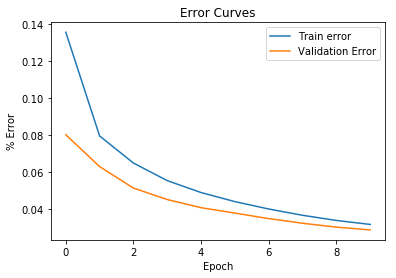

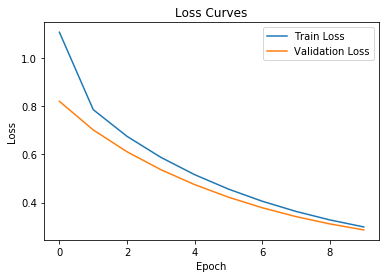

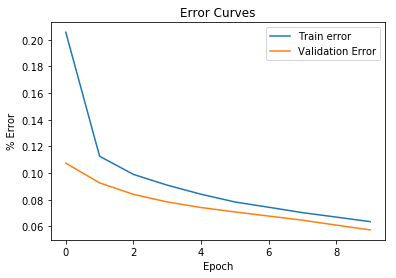

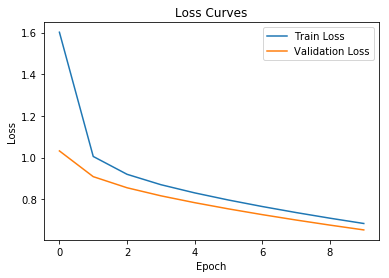

KeyboardInterrupt: 

In [107]:
hyperparameters={
    'hidden_units': [80,800],
    'reg': [[0.00005,0.00005],[0.0005,0.0005]],
    'batch_size': [100,400]
}
val_accuracy = [[[0]*len(hyperparameters['batch_size'])]*len(hyperparameters['reg'])]*(len(hyperparameters['hidden_units']))
for i in range(len(hyperparameters['hidden_units'])):
    for j in range(len(hyperparameters['reg'])):
        for k in range(len(hyperparameters['batch_size'])):
            NN_final = NeuralNet_matrix([data_train_MNIST.shape[1]-1,hyperparameters['hidden_units'][i],10],10,hyperparameters['reg'][j])
            NN_final.train(data_train_MNIST,.1,hyperparameters['batch_size'][k],num_epochs=10, data_val = data_val_MNIST,verbose=False)
            val_accuracy[i][j][k] = NN_final.eval_accuracy(data_val_MNIST)
            plot_model(NN_final)

In [ ]:
plot_model(NN_final,"final")

In [ ]:
print NN_final.eval_accuracy(data_test_MNIST)